In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.layers import Dense, Input, Conv1D, Flatten, MaxPooling2D, UpSampling2D, MaxPooling1D, UpSampling1D
from keras.callbacks import ModelCheckpoint

from mne.io import read_raw_brainvision as mne_read
from os.path import join
from os import listdir
import numpy as np

Using TensorFlow backend.


In [3]:
channels_num = 58
window_size = 500
nb_epoch = 50

# Hyper parameters
batch_size = 32
nb_visible = channels_num * window_size
nb_hidden = 1000
nb_emb = 20

corruption_level = 0.001

In [4]:
mne_format_data_dir = join('data', 'resting_state_mne_format')

In [5]:
def create_ae(dim = 1):

    nb_filter_1 = 64
    nb_filter_2 = 32
    filter_length = 5

    encoding_dim = dim

    input_ = Input(shape=(window_size, 1))

    encoder = Sequential((
        Conv1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='relu', padding='same', input_shape=(window_size, 1)),
        Dropout(0.4),
        MaxPooling1D(),
        Conv1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu', padding='same'),
        MaxPooling1D(),
        Dense(encoding_dim, activation='relu')
    ))
    print(encoder.summary())
    decoder = Sequential((
        Conv1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu', padding='same', input_shape=encoder.output_shape[-2:]),
        UpSampling1D(),
        Conv1D(nb_filter=nb_filter_1, filter_length=filter_length, padding='same', activation='relu'),
        UpSampling1D(),
        Conv1D(nb_filter=1, filter_length=filter_length, padding='same', activation='sigmoid')
    ))
    print(decoder.summary())
    autoencoder = Model(input_, decoder(encoder(input_)), name="autoencoder")
    autoencoder.compile(loss='mse', optimizer='adam', metrics=['mae']) # .compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.summary())
    return autoencoder

In [6]:
autoencoder = create_ae()

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="same", input_shape=(500, 1), filters=64, kernel_size=5)`
  if sys.path[0] == '':
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="same", filters=32, kernel_size=5)`
  from ipykernel import kernelapp as app
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", padding="same", input_shape=(125, 1), filters=32, kernel_size=5)`
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="same", activation="relu", filters=64, kernel_size=5)`
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 500, 64)           384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 32)           10272     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 125, 1)            33        
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
_________________________________________________________________
None
_

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
#scaler = StandardScaler()
mean, var = None, None

def cut_window(data):
    return data[:, :data.shape[1] - data.shape[1] % window_size]

def read_func(filename, verbose=0):
    d = mne_read(filename, verbose=verbose, preload=True)
    d.drop_channels(['VEOG', 'HEOG', 'STI 014'])
    d = d.get_data()
    return cut_window(d)

def read_data(data_type, return_batch_np=False):
    global mean, var
    ''' If return_batch_np is False
            return data with shape (None, batch_size, nb_visible)
        else number of batches in data
    '''
    verbose = None if return_batch_np else 0
    
    data_dir = join(mne_format_data_dir, data_type)
    data = np.hstack([read_func( join(data_dir, fn), verbose=verbose) for fn in listdir(data_dir) if fn[-5:] == '.vhdr'])
    
    if mean is None:
        mean, var = data.mean(), data.var()
    #data = scaler.transform(data)
    data = (data - mean) / (var ** (1/2))
    print(data_type, data.mean(), data.var())
    if return_batch_np:
        return data.shape[1] // window_size
    return data.T.reshape(-1, window_size, channels_num)

def gen(data_type):
    data = read_data(data_type)
    print(data.shape)
    for ep in range(nb_epoch+1):
        for x in data:
            t = x.T.reshape(channels_num, window_size, 1)
            yield t, t

In [9]:
train_batches_nb = read_data('train', return_batch_np=True)
val_batches_nb = read_data('validation', return_batch_np=True)

Extracting parameters from data/resting_state_mne_format/train/2505_shirokova_post_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 606599  =      0.000 ...   606.599 secs...
Extracting parameters from data/resting_state_mne_format/train/miloslavov_22_05_pre_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 603399  =      0.000 ...   603.399 secs...
Extracting parameters from data/resting_state_mne_format/train/gorin_rest_eeg_post_31011200.vhdr...
Setting channel info structure...
Reading 0 ... 603699  =      0.000 ...   603.699 secs...
Extracting parameters from data/resting_state_mne_format/train/2704_zagirova_post_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 604549  =      0.000 ...   604.549 secs...
Extracting parameters from data/resting_state_mne_format/train/2103_glebko_posteeg.vhdr...
Setting channel info structure...
Reading 0 ... 633899  =      0.000 ...   633.899 secs...
Extracting parameters from data/resting_state_mne_format/train/200317

In [10]:
history = autoencoder.fit_generator(gen('train'), steps_per_epoch=train_batches_nb, epochs=nb_epoch, \
                          validation_data=gen('validation'), validation_steps=val_batches_nb, \
                          #use_multiprocessing=True, \
                          callbacks=[ModelCheckpoint("models/cnn_%s_{epoch:02d}.hdf5" % ('1D'), save_best_only=False)])

Epoch 1/50
train -6.94135875275e-16 1.0
(29879, 500, 58)
29876/29879 [============================>.] - ETA: 0s - loss: 0.8624 - mean_absolute_error: 0.2003validation -0.167214278797 0.135945376935
(3149, 500, 58)
29879/29879 [==============================] - 564s - loss: 0.8623 - mean_absolute_error: 0.2003 - val_loss: 0.1414 - val_mean_absolute_error: 0.2553
Epoch 2/50
29879/29879 [==============================] - 526s - loss: 0.8621 - mean_absolute_error: 0.1997 - val_loss: 0.1414 - val_mean_absolute_error: 0.2560
Epoch 3/50
29879/29879 [==============================] - 524s - loss: 0.8621 - mean_absolute_error: 0.1997 - val_loss: 0.1415 - val_mean_absolute_error: 0.2571
Epoch 4/50
29879/29879 [==============================] - 524s - loss: 0.8621 - mean_absolute_error: 0.1995 - val_loss: 0.1415 - val_mean_absolute_error: 0.2575
Epoch 5/50
27887/29879 [==========================>...] - ETA: 34s - loss: 0.9176 - mean_absolute_error: 0.1992

KeyboardInterrupt: 

In [13]:
#test = next(gen('test'))

In [13]:
#test[0]

In [14]:
#autoencoder.predict(test[0])

In [9]:
test_batches_nb = read_data('test', return_batch_np=True)

Extracting parameters from data/resting_state_mne_format/test/zavrin_eyes_closed_eeg_15021500.vhdr...
Setting channel info structure...
Reading 0 ... 302749  =      0.000 ...   302.749 secs...
Extracting parameters from data/resting_state_mne_format/test/zavrin_15021500_eyesclosed_post_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 319299  =      0.000 ...   319.299 secs...
Extracting parameters from data/resting_state_mne_format/test/300120171600_dagaev_rest_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 615599  =      0.000 ...   615.599 secs...
Extracting parameters from data/resting_state_mne_format/test/tsoy_pre_eeg_2504.vhdr...
Setting channel info structure...
Reading 0 ... 652699  =      0.000 ...   652.699 secs...
test 5.32180965766e-17 1.0


In [22]:
import matplotlib.pyplot as plt
from keras.models import load_model
autoencoder = load_model('models/cnn_1000_14.hdf5')

In [23]:
def metric(y_true, y_pred):
    l2ratio = np.sum((y_true - y_pred)**2) / np.sum(y_true**2)
    return np.sqrt(l2ratio) * 100

In [24]:
x = []
i = 0
for test in gen('test'):
    i += 1
    x.append(metric(autoencoder.predict(test[0]), test[1]))
    if (i % 50) == 0:
        print(np.mean(x))

test 5.32180965766e-17 1.0
(3779, 500, 60, 1)
111.774412141
125.433993282
114.679389348
125.21433792
119.025777582
122.287779607
122.152881824
120.186362238
122.874351412
119.778719415
123.237461309
121.062657803
121.820334971
122.152321635
120.719816696
122.548540117
120.699764559
122.549708342
121.599612298
121.683399767
122.152163515
120.939425842
122.417702273
121.09718042
122.233101457
121.848408948
121.617426408
122.151404316
121.17889819
122.345687841
121.393867103


KeyboardInterrupt: 

In [11]:
autoencoder.evaluate_generator(gen('test'), steps=test_batches_nb)

test 5.32180965766e-17 1.0
(3779, 500, 60, 1)


[0.60504258853399151, 0.58064251835063352]

In [12]:
autoencoder.metrics_names

['loss', 'mean_absolute_error']

In [ ]:
history.history

In [ ]:
autoencoder.save('test.h5')

In [11]:
test = next(gen('test'))

In [47]:
test[0].shape

(64, 61)

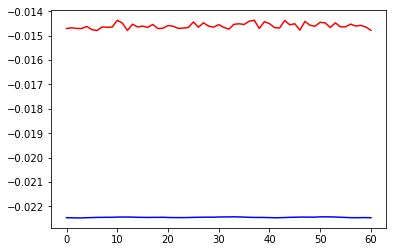

In [73]:
def show_test(n):
    plt.plot(np.arange(test[0][n].size), (test[0][n] * var ** (1/2) + mean).flatten(), color='b')
    res = autoencoder.predict(test[0][n].reshape(1, -1))
    plt.plot(np.arange(res.size), (res * var ** (1/2) + mean).flatten(), color='r')
    plt.show()
    
show_test(7)

In [76]:
test[0][0]

array([-1.19735468, -1.19766106, -1.1981571 , -1.19840395, -1.19839296,
       -1.19832731, -1.19817781, -1.19847933, -1.19851823, -1.19842214,
       -1.19833343, -1.1980574 , -1.19771942, -1.19723923, -1.19724166,
       -1.1972793 , -1.1971869 , -1.19685378, -1.19702642, -1.19726958,
       -1.19745194, -1.19777417, -1.19786414, -1.19775832, -1.19789935,
       -1.19814863, -1.19816809, -1.19852309, -1.1986118 , -1.19873707,
       -1.19857532, -1.19835892, -1.19795411, -1.19737783, -1.19721365,
       -1.19723554, -1.19742403, -1.19722338, -1.19716016, -1.19750058,
       -1.19784099, -1.19789332, -1.19791394, -1.1980076 , -1.19825076,
       -1.19836135, -1.19826535, -1.19845861, -1.19871762, -1.19881605,
       -1.19838566, -1.1978264 , -1.19747996, -1.1974143 , -1.19754075,
       -1.1975991 , -1.19777777, -1.1974143 , -1.19744465, -1.1975565 ,
       -1.19786171])

In [75]:
autoencoder.predict(test[0][0].reshape(1, -1))

array([[-0.81068474, -0.80941945, -0.81093025, -0.81085229, -0.80660617,
        -0.81327504, -0.81492221, -0.80790353, -0.80843753, -0.80828446,
        -0.79405653, -0.79962194, -0.81512022, -0.80202258, -0.80774528,
        -0.80601555, -0.80853337, -0.80269289, -0.81089044, -0.81020975,
        -0.80502218, -0.80605251, -0.81084102, -0.8100906 , -0.80870497,
        -0.79747999, -0.80827975, -0.79939252, -0.80619758, -0.80837649,
        -0.80311096, -0.80861604, -0.8124631 , -0.8023845 , -0.80139577,
        -0.80273634, -0.79608792, -0.7938416 , -0.81079549, -0.79689747,
        -0.80076027, -0.8090685 , -0.80986834, -0.79452288, -0.80349278,
        -0.80141538, -0.81425375, -0.79669464, -0.80475599, -0.80646384,
        -0.7984153 , -0.79969573, -0.80898458, -0.7993139 , -0.8075695 ,
        -0.80733687, -0.80190003, -0.80580699, -0.80462283, -0.80776191,
        -0.81464827]], dtype=float32)

In [26]:
autoencoder.evaluate_generator(gen('test'), steps=test_batches_nb)

0.0027330162475785683